In [52]:
# Not as detailed maybe as check_ptm_results, but intended to look for weirdness
# in a production run for sfb_ocean.

In [53]:
import xarray as xr
import matplotlib.pyplot as plt
from stompy import utils
from matplotlib import cm
import numpy as np
import six
import os
import pandas as pd
from stompy.grid import unstructured_grid
from stompy.model.fish_ptm import ptm_tools
%matplotlib notebook

In [54]:
date_str='20170730'

In [55]:
try:
    ptm_hyd.close()
except NameError:
    pass
ptm_hyd=xr.open_dataset(f'/opt2/sfb_ocean/suntans/runs/merged_021_{date_str}/ptm_average.nc_0000.nc')

In [56]:
try:
    sun_hyd.close()
except NameError:
    pass

sun_hyd=xr.open_dataset(f'/opt2/sfb_ocean/suntans/runs/merged_021_{date_str}/average.nc_0000.nc')

sun_hyd=sun_hyd.rename_vars(dict(Nk='Nkc'))

In [57]:
g=unstructured_grid.UnstructuredGrid.from_ugrid(ptm_hyd)

In [58]:
ptm_run_dir=f'/opt2/sfb_ocean/ptm/all_source_021d/chunk00/{date_str}'

pbA=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_up50000_rel{date_str}_bin.out'))
pbB=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_up5000_rel{date_str}_bin.out'))
pbC=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_up500_rel{date_str}_bin.out'))
pbD=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_none_rel{date_str}_bin.out'))
pbE=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_down500_rel{date_str}_bin.out'))
pbF=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_down5000_rel{date_str}_bin.out'))
pbG=ptm_tools.PtmBin(os.path.join(ptm_run_dir,f'Alameda_Creek_down50000_rel{date_str}_bin.out'))


In [59]:
pbs=[pbA,pbB,pbC,pbD,pbE,pbF,pbG]

nt_max=pbs[0].count_timesteps()
nt=min(nt_max,200)
npart=10
posns=np.zeros((nt,len(pbs),npart,3),np.float64)
times=np.zeros(nt,'M8[us]')
steps=range(nt)

for pbi,pb in enumerate(pbs):
    for ti,ts in enumerate(steps):
        d,parts=pb.read_timestep(ts)
        posns[ti,pbi,:,:]=parts['x'][:npart,:]        
        times[ti]=utils.to_dt64(d)
theta=115.*np.pi/180.
vec_long=np.r_[ np.cos(theta), np.sin(theta), 0]

<IPython.core.display.Javascript object>


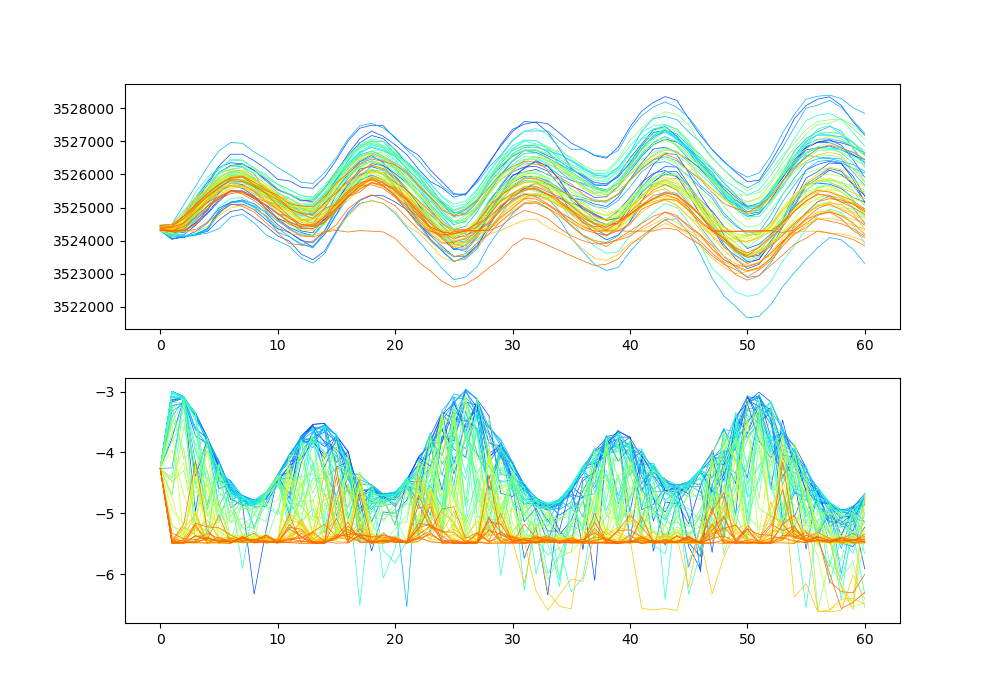

In [60]:
fig,(ax_long,ax_z)=plt.subplots(2,1,figsize=(10,7))

colors=cm.jet(np.linspace(0.2,0.8,len(pbs)))

for pbi,col in zip(range(len(pbs)),colors):
    for p in range(npart):
        coord=posns[:,pbi,p,:].dot(vec_long)
        ax_long.plot(steps, coord, color=col,lw=0.5)
        ax_z.plot(steps,posns[:,pbi,p,2],color=col,lw=0.5)
        

In [61]:
part_i=0
xyz=posns[:,0,part_i,:]

part_df=pd.DataFrame(dict(time=times,x=xyz[:,0],y=xyz[:,1],z=xyz[:,2]))

In [62]:
# What *should* the particles horizontal velocity be?
#def part_hydro_vel(t,xyz):

part_df['cell']=[ g.select_cells_nearest( xyz[:2],inside='try')
                 for xyz in part_df.loc[:,['x','y','z']].values ]

In [63]:
part_df.head()

,time,x,y,z,cell
0,2017-07-30 00:00:00,576637.083020,4.157681e+06,-4.264924,23161
1,2017-07-30 01:00:00,576747.504338,4.157586e+06,-2.999803,8496
2,2017-07-30 02:00:00,576362.200960,4.157687e+06,-3.105863,12915
3,2017-07-30 03:00:00,576136.923717,4.158201e+06,-3.728981,12887
4,2017-07-30 04:00:00,575969.972661,4.158585e+06,-3.848335,12883


In [64]:
z_bed=-ptm_hyd.Mesh2_face_depth.values
part_df['z_bed']=z_bed[ part_df['cell'].values ]

In [65]:
# Eta - gets linearly interpolated.

hyd_times=ptm_hyd.Mesh2_data_time.values
# side='right' gives alpha in [0,1.)
# otherwise get alpha in (0,1]
hydro_step=np.searchsorted(hyd_times,part_df['time'],side='left')
assert np.all(hydro_step>=0)


In [66]:
eta=np.diag(ptm_hyd.Mesh2_sea_surface_elevation.isel(nMesh2_data_time=hydro_step,
                                                     nMesh2_face=part_df['cell']).values)

part_df['eta']=eta


In [67]:
# Particle velocity -- reflects preceding interval
dt=np.r_[1,np.diff(part_df['time'])/np.timedelta64(1,'s')]
dx=np.r_[0,np.diff(part_df['x'].values)]
dy=np.r_[0,np.diff(part_df['y'].values)]
part_df['u']=dx/dt
part_df['v']=dy/dt

In [68]:
np.all(sun_hyd.time.values[:-1]==ptm_hyd.Mesh2_data_time.values)

True

In [69]:
sun_hyd.z_w

<xarray.DataArray 'z_w' (Nkw: 61)>
array([0.000000e+00, 4.387286e-01, 9.322983e-01, 1.487564e+00, 2.112238e+00,
       2.814997e+00, 3.605600e+00, 4.495029e+00, 5.495636e+00, 6.621319e+00,
       7.887712e+00, 9.312405e+00, 1.091518e+01, 1.271831e+01, 1.474683e+01,
       1.702891e+01, 1.959625e+01, 2.248451e+01, 2.573380e+01, 2.938926e+01,
       3.350164e+01, 3.812808e+01, 4.333282e+01, 4.918815e+01, 5.577540e+01,
       6.318605e+01, 7.152303e+01, 8.090214e+01, 9.145364e+01, 1.033241e+02,
       1.166783e+02, 1.317018e+02, 1.486033e+02, 1.676174e+02, 1.890083e+02,
       2.130731e+02, 2.401460e+02, 2.706030e+02, 3.048671e+02, 3.434142e+02,
       3.867797e+02, 4.355659e+02, 4.904503e+02, 5.521953e+02, 6.216585e+02,
       6.998045e+02, 7.877188e+02, 8.866224e+02, 9.978889e+02, 1.123064e+03,
       1.263885e+03, 1.422310e+03, 1.600537e+03, 1.801043e+03, 2.026612e+03,
       2.280378e+03, 2.565863e+03, 2.887035e+03, 3.248353e+03, 3.654836e+03,
       4.112129e+03])
Coordinates:
    z_

In [70]:
ucs=[]
vcs=[]
sun_ks=[]
is_lump=[]

# first value in z_w is not an interface.
z_w=sun_hyd.z_w.values[1:]

dzmin_surface=0.25

# SUNTANS average output velocity:
for idx,row in part_df.iterrows():
    ti=hydro_step[idx]
    eta=sun_hyd.eta.isel(time=ti,Nc=row['cell']).item()
    depth=sun_hyd.dv.isel(Nc=row['cell']).item()
    
    k,ktop,kbot=np.searchsorted( z_w,[-row['z'],-eta,depth] )
    if k==ktop and (eta+z_w[ktop]<dzmin_surface) and (ktop<kbot):
        k=ktop+1
        is_lump.append(1)
    else:
        is_lump.append(0)
    sun_ks.append(k)
    sun_uc=sun_hyd.uc.isel(time=ti,Nc=row['cell'],Nk=k).item()
    sun_vc=sun_hyd.vc.isel(time=ti,Nc=row['cell'],Nk=k).item()
    ucs.append(sun_uc)
    vcs.append(sun_vc)
    
part_df['sun_uc']=ucs
part_df['sun_vc']=vcs
part_df['sun_k']=sun_ks
part_df['is_lump']=is_lump

In [71]:
part_df

,time,x,y,z,cell,z_bed,eta,u,v,sun_uc,sun_vc,sun_k,is_lump
0,2017-07-30 00:00:00,576637.083020,4.157681e+06,-4.264924,23161,-5.495636,0.000000,0.000000,0.000000,0.000000,0.000000,6,0
1,2017-07-30 01:00:00,576747.504338,4.157586e+06,-2.999803,8496,-5.495636,-2.994643,0.030673,-0.026129,-0.012729,-0.049887,5,0
2,2017-07-30 02:00:00,576362.200960,4.157687e+06,-3.105863,12915,-5.495636,-3.082742,-0.107029,0.027982,-0.082035,0.100692,5,0
3,2017-07-30 03:00:00,576136.923717,4.158201e+06,-3.728981,12887,-5.495636,-3.353714,-0.062577,0.142787,-0.056443,0.120400,6,0
4,2017-07-30 04:00:00,575969.972661,4.158585e+06,-3.848335,12883,-5.495636,-3.738555,-0.046375,0.106718,-0.072131,0.117171,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,2017-08-01 08:00:00,573850.787627,4.160608e+06,-4.631488,16470,-6.621319,-4.571218,-0.048452,0.037879,-0.088550,0.031743,7,0
57,2017-08-01 09:00:00,573464.221362,4.160502e+06,-5.222340,16970,-6.621319,-4.816094,-0.107380,-0.029301,-0.075058,-0.034705,7,0
58,2017-08-01 10:00:00,573368.210486,4.160172e+06,-5.069332,16160,-6.621319,-4.927343,-0.026670,-0.091894,-0.025598,-0.091309,7,0
59,2017-08-01 11:00:00,573491.646160,4.159689e+06,-5.048379,16182,-6.621319,-4.868400,0.034288,-0.133941,0.044093,-0.125986,7,0


<IPython.core.display.Javascript object>


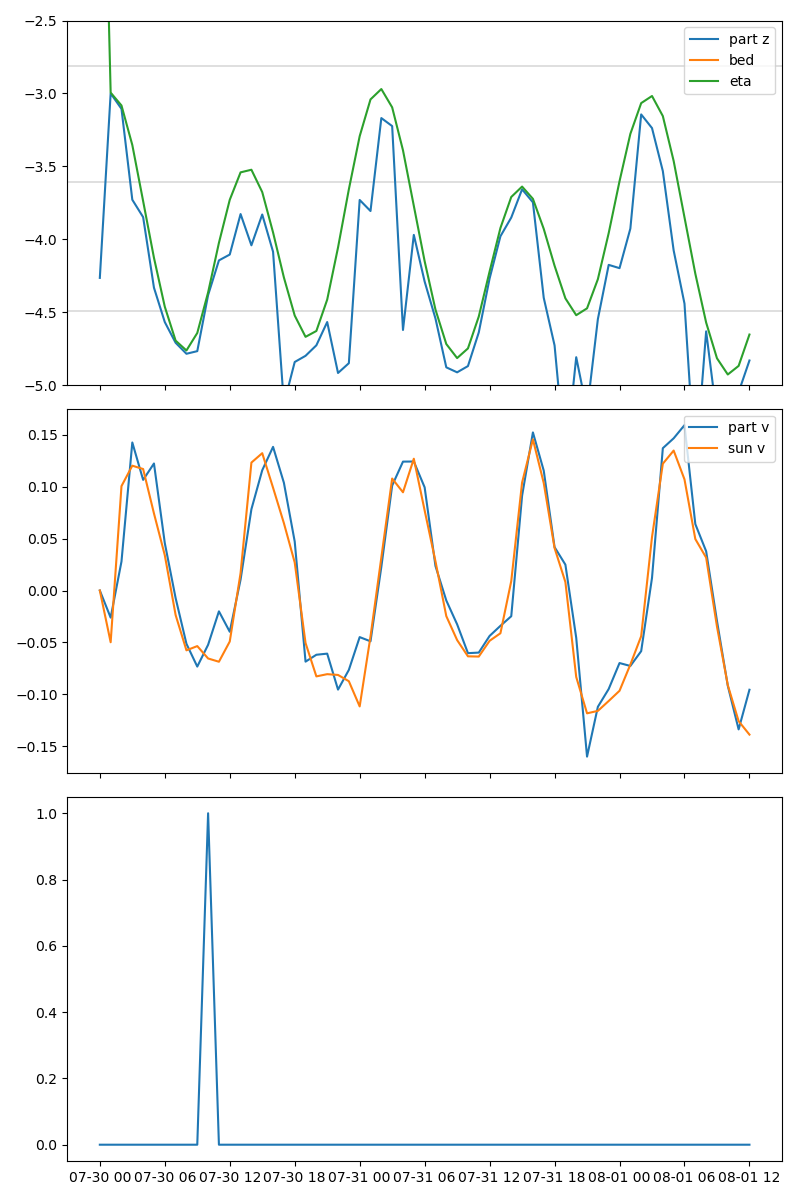

In [72]:
fig,(ax_z,ax_vel,ax_lump)=plt.subplots(3,1,sharex=True,figsize=(8,12))

ax_z.plot(part_df.time,part_df.z,label='part z')
ax_z.plot(part_df.time,part_df.z_bed,label='bed')
ax_z.plot(part_df.time,part_df.eta,label='eta')

for z in sun_hyd.z_w.values[1:-1]:
    ax_z.axhline(-z,color='0.4',lw=0.3,zorder=-2,label='__nolabel__')

ax_z.legend(loc='upper right')
ax_z.axis(ymax=-2.5,ymin=-5)

#ax_vel.plot(part_df.time,part_df.u,label='part u')
ax_vel.plot(part_df.time,part_df.v,label='part v')
#ax_vel.plot(part_df.time,part_df.ptm_u,label='ptm u')
#ax_vel.plot(part_df.time,part_df.ptm_v,label='ptm v')
#ax_vel.plot(part_df.time,part_df.sun_uc,label='sun u')
ax_vel.plot(part_df.time,part_df.sun_vc,label='sun v')

ax_vel.legend(loc='upper right')

ax_lump.plot(part_df.time,part_df.is_lump,label='surface lumped')
fig.tight_layout()

<IPython.core.display.Javascript object>


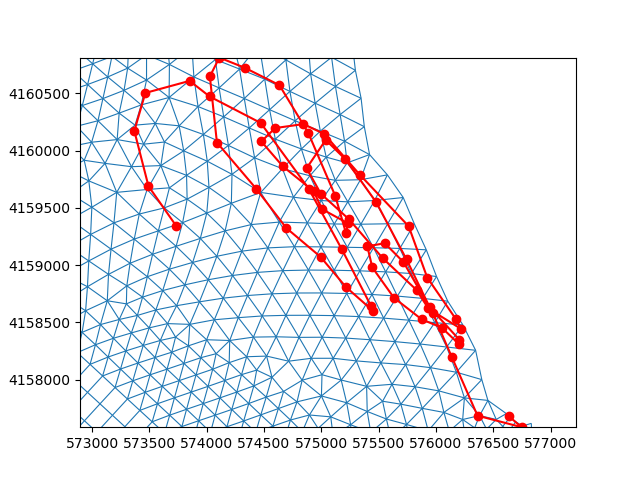

(573368.2104856152, 576747.5043377636, 4157586.488586282, 4160810.963338108)

In [73]:
fig,ax=plt.subplots()
g.plot_edges()
plt.plot( part_df['x'],part_df['y'],'r-o')
ax.set_adjustable('datalim')

ax.axis((part_df['x'].min(),
         part_df['x'].max(),
         part_df['y'].min(),
         part_df['y'].max()))